# Basic tutorial: ``Interleaving`` class

This class encodes all the information needed to figureout an interleaving between two ``MapperGraph`` instances. 


In [1]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt

We have two example Mapper graphs to work with. 

Text(0.5, 1.0, 'M_1')

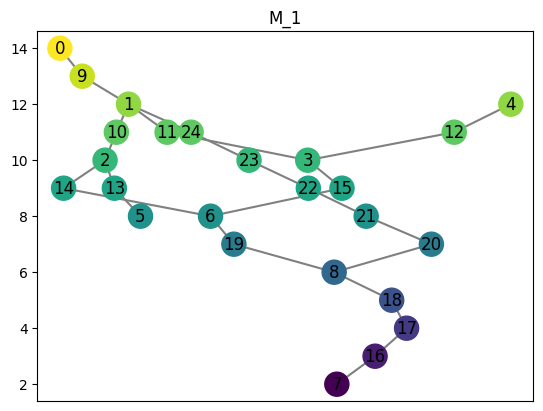

In [2]:
M1 = ex_mg.interleave_example_A()
M1.draw()
plt.title('M_1')

Text(0.5, 1.0, 'M_2')

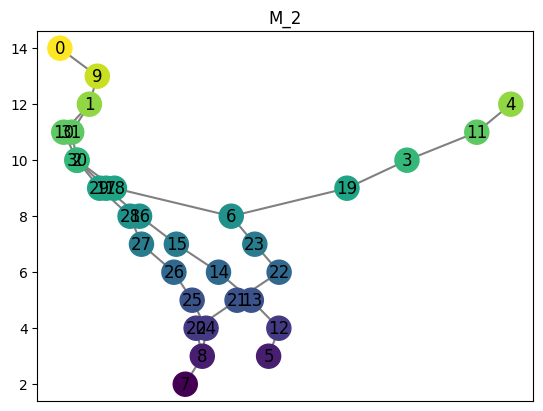

In [3]:
M2 = ex_mg.interleave_example_B()
M2.draw()
plt.title('M_2')

We can create an instance of the interleaving class to store all the relevant matrices and smoothed graphs. 

In [4]:
myInt = Interleave(M1, M2)

Inside of the  `Interleave` class, we have lots of setup data ready to go. 

Internally, the two graphs are labeled as $F$ and $G$, and an interleaving itself is a pair of maps $\phi:F \to G^n$ and $\psi: G \to F^n$. 

First we have the two original graphs stored as follows. The $F$ graphs for $0$, $n$, and $2n$ are in a dictionary `myInt.F` with keys `['0','n','2n']`. (Note the `0` is a string, not an integer).

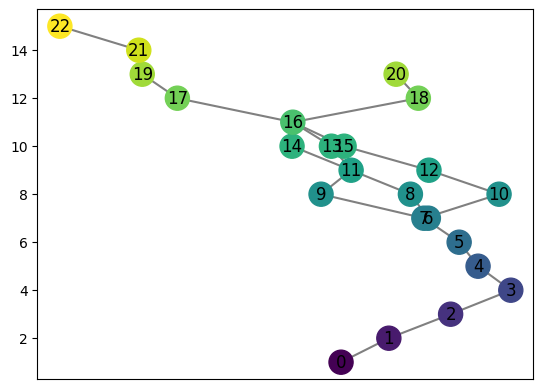

In [5]:
myInt.F['n'].draw()

In [6]:
for key in ['0', 'n', '2n']:
    print(f"F_{key}: {myInt.F[key].summary()}")

F_0: {'nodes': 25, 'edges': 26}
F_n: {'nodes': 23, 'edges': 24}
F_2n: {'nodes': 22, 'edges': 22}


Similarly, we have a dictionary of the $G$ graphs. 

In [7]:
for key in ['0', 'n', '2n']:
    print(f"G_{key}: {myInt.G[key].summary()}")

G_0: {'nodes': 32, 'edges': 32}
G_n: {'nodes': 32, 'edges': 32}
G_2n: {'nodes': 32, 'edges': 32}


## Matrices 

There are many matrices stored in the `Interleave` class, but since these are largely block matrices due to the function preserving restriction on the maps, we store these in the following structure. 

A block dictionary is a dictionary with keys as the integer function values for the relevant graphs. Each key $i$ maps to another dictionary with keys
- `array`: the matrix for the $i$ th block
- `rows`: A list of the vertices (or edges) in order represented in the rows of the matrix
- `cols`: A list of the vertices (or edges) in order represented in the rows of the matrix. 

### Matrices for Maps Induced by Inclusion
The first block matrices are the inclusion matrices, stored as a dictionary `Interleave.I`, which give the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$. 

In [8]:
# For example, the induced inclusion map from $F_n$ to $F_{2n}$ for the vertices is given by:
myInt.I['F']['n']['V']

# The block of the diagram sending vertices with function value 7 in $V(F_n)$ to vertices with value 7 in $V(F_{2n})$ is given by:
myInt.I['F']['n']['V'][7]

{'rows': [8, 9],
 'cols': [6, 7],
 'array': array([[0., 1.],
        [1., 0.]])}

Reading the output above, we see that vertex 6 in $F_n$ is sent to vertex $9$ in $F_{2n}$, while vertex 7 in $F_n$ is sent to vertex $8$ in $F_{2n}$

There are also commands for converting this block dictionary to a full matrix dictionary:

In [9]:
I_matrix = myInt.block_dict_to_matrix(myInt.I['F']['n']['V'])

# Note that this returns a dictionary with the rows, cols, and array
I_matrix.keys()

dict_keys(['rows', 'cols', 'array'])

And for visualizing, we can use the draw function to plot the matrix with rows and columns labeled accordingly. 

Text(0.5, 1.0, 'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Vertices')

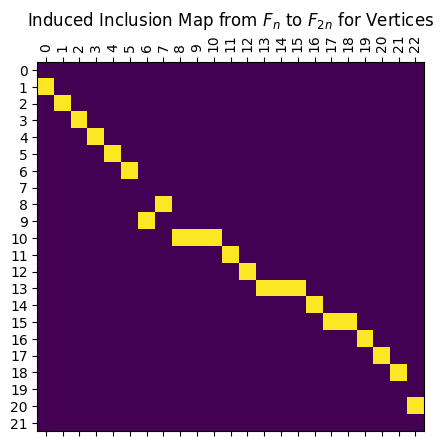

In [10]:
myInt.draw_matrix(myInt.I['F']['n']['V'])
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Vertices')

We also have the induced maps for edges. This can be found as follows, or the full matrix can be drawn directly using the `draw_I` command. Note that the third entry for edge labels comes from the `nx.MultiDiGraph` parent class. 

{'rows': [(10, 11, 0), (10, 12, 0)], 'cols': [(8, 11, 0), (9, 11, 0), (10, 12, 0)], 'array': array([[1., 1., 0.],
       [0., 0., 1.]])}


Text(0.5, 1.0, 'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Edges with Function Value 8')

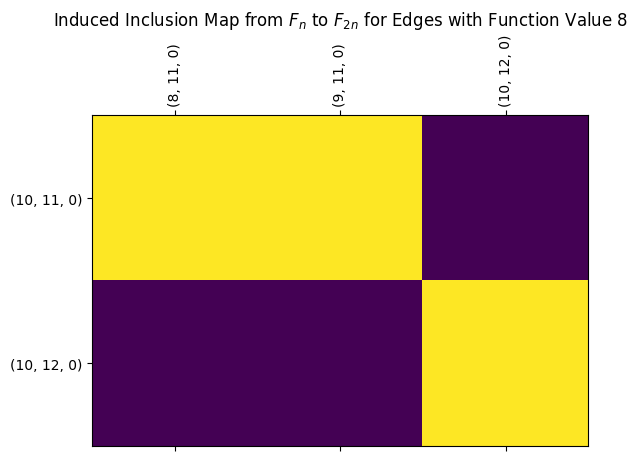

In [11]:
print(myInt.I['F']['n']['E'][8])

myInt.draw_matrix(myInt.I['F']['n']['E'][8])
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Edges with Function Value 8')

Text(0.5, 1.0, 'Induced Inclusion Map from $G_0$ to $G_{n}$ for Edges')

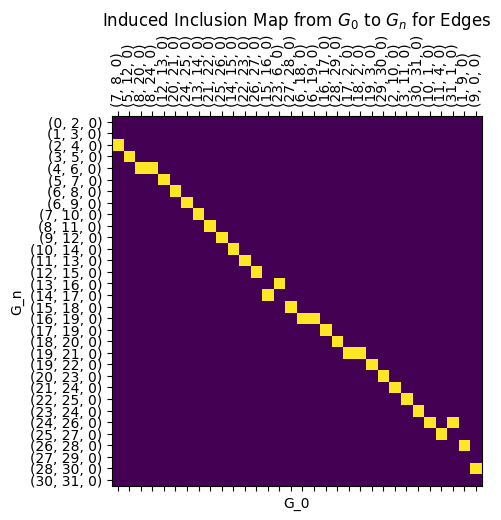

In [12]:
# myInt.I['F'].keys()
myInt.draw_I('G', '0', 'E')
plt.title(r'Induced Inclusion Map from $G_0$ to $G_{n}$ for Edges')

### Boundary Matrices

We also have boundary matrices for each graph, where $B[v,e] = 1$ iff $v$ is a vertex of edge $e$.  Note that unlike the inclusion matrices, we don't have separate vertex and edge versions, and we don't have the nice block structure,  so this can be found as follows.

In [13]:
myInt.B['F']['n'].keys()

dict_keys(['rows', 'cols', 'array'])

We also have a drawing command, `Interleave.draw_B` to simplify the process.

<Axes: title={'center': 'B(F_2n)'}, xlabel='E(F_2n)', ylabel='V(F_2n)'>

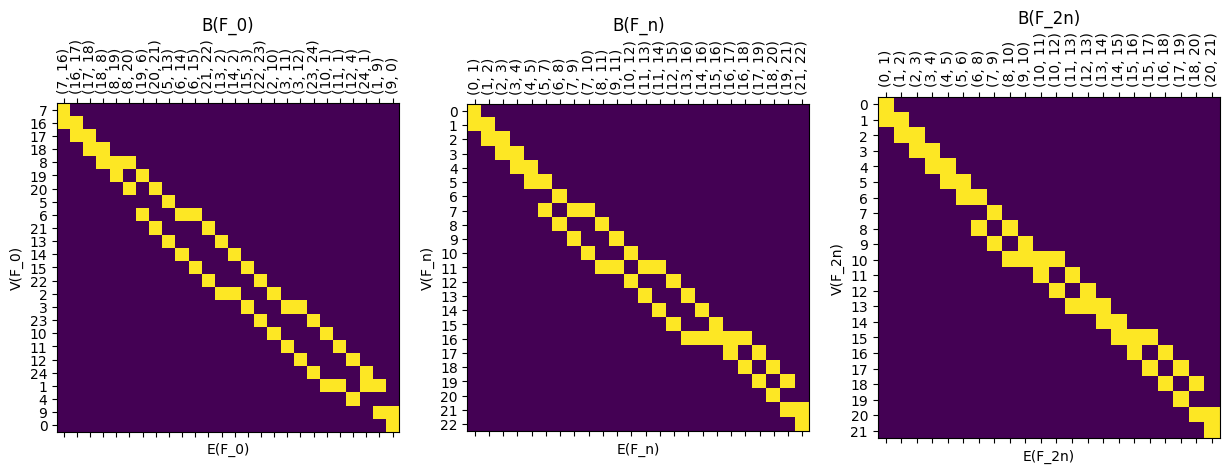

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
myInt.draw_B('F', '0', ax=axs[0])
myInt.draw_B('F', 'n', ax=axs[1])
myInt.draw_B('F', '2n', ax=axs[2])

### Distance matrix 

Following (our arXiv paper that we should cite), there is a distance between any vertices at the same level defined to be the amount of smoothing needed for the two vertices to be mapped to the same vertex. This block matrix is stored in `Interleave.D`. 

In [15]:
# Here's the distance between the vertices at function value 9 in $F$
print(myInt.D['F']['0'][9])

{'rows': [13, 14, 15, 22], 'cols': [13, 14, 15, 22], 'array': array([[0., 1., 1., 3.],
       [1., 0., 1., 3.],
       [1., 1., 0., 3.],
       [3., 3., 3., 0.]])}


AttributeError: 'Axes' object has no attribute 'colorbar'

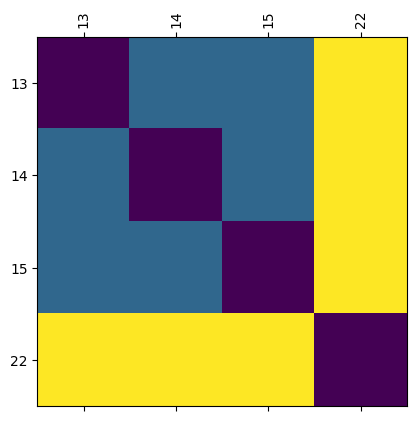

In [16]:
# and here's a visual for the same distance matrix
ax = myInt.draw_matrix(myInt.D['F']['0'][9], colorbar = True)
plt.title(r'Distance Matrix for Vertices with Function Value 9 in $F$')

As before, we can easily draw the full distance matrix using the `draw_D` command. Here's the full matrix for $G_{n}$.

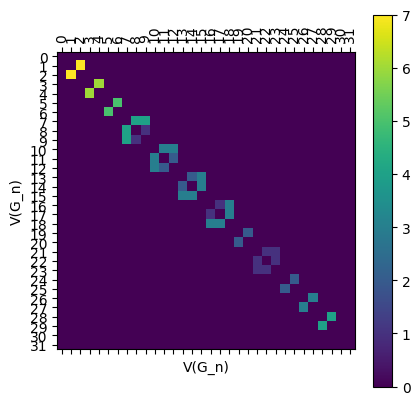

In [ ]:
myInt.draw_D('G', 'n')

## Initializing a random interleaving 

Let's go back to a simpler example for a while. We'll compare the distance between a torus and a line graph. 

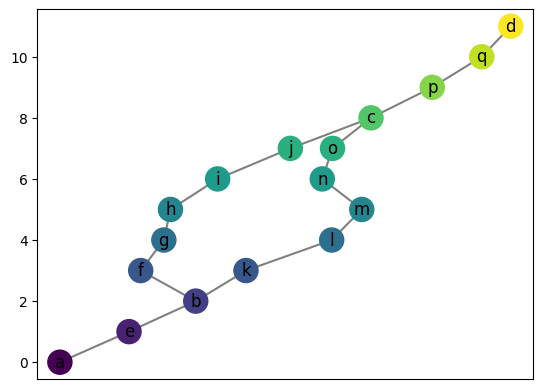

In [ ]:
T = ex_mg.torus(0, 2, 8, 11, delta = 1, seed = 17)
T.draw()

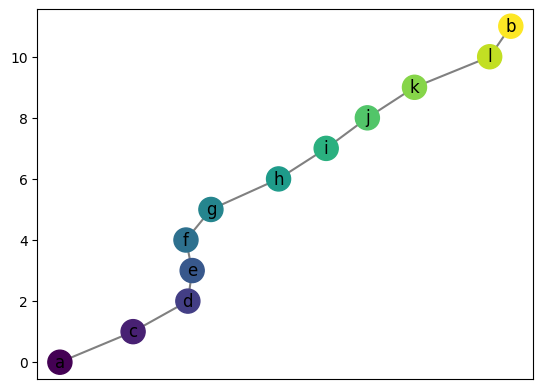

In [ ]:
L = ex_mg.line(0, 11)
L.draw()

As before, we can intialize the interleaving. This time, however, we ask for randomly generated maps $\phi: F \to G^n$ and $\psi: G \to F^n$. 

In [ ]:
myInt = Interleave(L,T, initialize_random_maps = True)

These are stored in `Interleave.phi`. In this case, the random generator creates the vertex map `Interleave.phi['V']` and the edge version is calculated by the matrix multiplications

$$
\phi_E = B_{G^n}^T \cdot \phi_V \cdot B_F
$$

and 

$$
\psi_E = B_{F^n}^T \cdot \psi_V \cdot  B_G
$$


Text(0.5, 1.0, 'Initial Random Map phi_V')

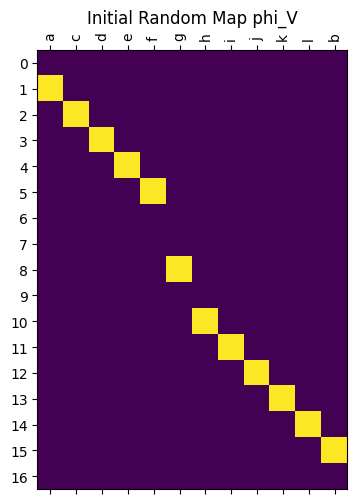

In [ ]:
phi = myInt.block_dict_to_matrix(myInt.phi['V'])
myInt.draw_matrix(phi)
plt.title(r'Initial Random Map phi_V')

Text(0.5, 1.0, 'Initial Random Map phi_E')

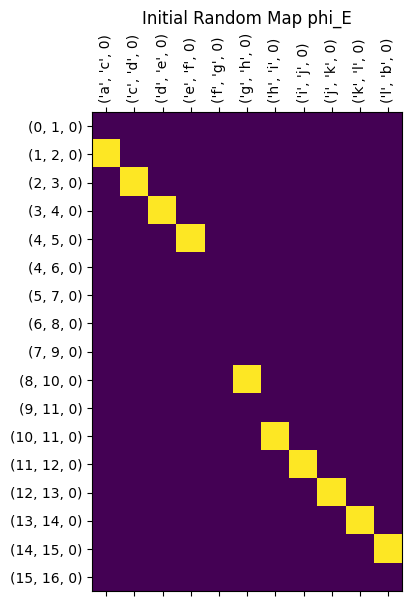

In [ ]:
phi = myInt.block_dict_to_matrix(myInt.phi['E'])
myInt.draw_matrix(phi)
plt.title('Initial Random Map phi_E')